In [1]:
import numpy as np
import scipy.constants as spc


In [2]:
a    = 5.431
hbar  = spc.hbar
           
_2pi_over_a = 2*np.pi / a
sqrt3 = np.sqrt(3)

# params from (Phys. Rev. B 69 115201 (2004)

# two-centre Slater–Koster integrals
V = {
    'ss_sigma'      : -1.95933,
    's_star_s_star' : -4.24135,
    'ss_star_sigma' : -1.52230,
    'sp_sigma'      :  3.02562,
    's_star_p_sigma':  3.15565,
    'sd_sigma'      : -2.28485,
    's_star_d_sigma': -0.80993,
    'pp_sigma'      :  4.10364,
    'pp_pi'         : -1.51801,
    'pd_sigma'      : -1.35554,
    'pd_pi'         :  2.38479,
    'dd_sigma'      : -1.68136,
    'dd_pi'         :  2.58880,
    'dd_delta'      : -1.81400,

    # atomic spin-orbit coupling (p-manifold)
    'SOC'           :  0.01989
}

# on-site energies
E = {
    's'   : -2.15168,
    'px'  :  4.22925, 'py' : 4.22925, 'pz' : 4.22925,
    'dxy' : 13.78950, 'dyz': 13.78950, 'dzx': 13.78950,
    'dx2y2':13.78950, 'dz2': 13.78950,
    's*'  : 19.11650
}




SK = {
    # ---------------- s / s* blocks ----------------
    ('s',  's')      : lambda l,m,n,V:  V['ss_sigma'],
    ('s',  's*')     : lambda l,m,n,V:  V['ss_star_sigma'],
    ('s*', 's')      : lambda l,m,n,V:  V['ss_star_sigma'],
    ('s*', 's*')     : lambda l,m,n,V:  V['s_star_s_star'],

    # ---------------- s – p  -----------------------
    ('s',  'px')     : lambda l,m,n,V:  l * V['sp_sigma'],
    ('px', 's')      : lambda l,m,n,V: -l * V['sp_sigma'],
    ('s',  'py')     : lambda l,m,n,V:  m * V['sp_sigma'],
    ('py', 's')      : lambda l,m,n,V: -m * V['sp_sigma'],
    ('s',  'pz')     : lambda l,m,n,V:  n * V['sp_sigma'],
    ('pz', 's')      : lambda l,m,n,V: -n * V['sp_sigma'],

    # ---------------- s* – p  ----------------------
    ('s*','px')      : lambda l,m,n,V:  l * V['s_star_p_sigma'],
    ('px','s*')      : lambda l,m,n,V: -l * V['s_star_p_sigma'],
    ('s*','py')      : lambda l,m,n,V:  m * V['s_star_p_sigma'],
    ('py','s*')      : lambda l,m,n,V: -m * V['s_star_p_sigma'],
    ('s*','pz')      : lambda l,m,n,V:  n * V['s_star_p_sigma'],
    ('pz','s*')      : lambda l,m,n,V: -n * V['s_star_p_sigma'],

    # ---------------- s – d  -----------------------
    ('s','dxy')      : lambda l,m,n,    V:  sqrt3*l*m               * V['sd_sigma'],
    ('dxy','s')      : lambda l,m,n,V:  sqrt3*l*m               * V['sd_sigma'],
    ('s','dyz')      : lambda l,m,n,V:  sqrt3*m*n               * V['sd_sigma'],
    ('dyz','s')      : lambda l,m,n,V:  sqrt3*m*n               * V['sd_sigma'],
    ('s','dzx')      : lambda l,m,n,V:  sqrt3*n*l               * V['sd_sigma'],
    ('dzx','s')      : lambda l,m,n,V:  sqrt3*n*l               * V['sd_sigma'],
    ('s','dx2y2')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['sd_sigma'],
    ('dx2y2','s')    : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['sd_sigma'],
    ('s','dz2')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['sd_sigma'],
    ('dz2','s')      : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['sd_sigma'],

    # ---------------- s* – d  ----------------------
    ('s*','dxy')     : lambda l,m,n,V:  sqrt3*l*m               * V['s_star_d_sigma'],
    ('dxy','s*')     : lambda l,m,n,V:  sqrt3*l*m               * V['s_star_d_sigma'],
    ('s*','dyz')     : lambda l,m,n,V:  sqrt3*m*n               * V['s_star_d_sigma'],
    ('dyz','s*')     : lambda l,m,n,V:  sqrt3*m*n               * V['s_star_d_sigma'],
    ('s*','dzx')     : lambda l,m,n,V:  sqrt3*n*l               * V['s_star_d_sigma'],
    ('dzx','s*')     : lambda l,m,n,V:  sqrt3*n*l               * V['s_star_d_sigma'],
    ('s*','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['s_star_d_sigma'],
    ('dx2y2','s*')   : lambda l,m,n,V: (sqrt3/2)*(l**2-m**2)    * V['s_star_d_sigma'],
    ('s*','dz2')     : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['s_star_d_sigma'],
    ('dz2','s*')     : lambda l,m,n,V:  0.5*(3*n**2-1)          * V['s_star_d_sigma'],

    # ---------------- p – p  -----------------------
    ('px','px')      : lambda l,m,n,V:  l**2 * V['pp_sigma'] + (1-l**2) * V['pp_pi'],
    ('py','py')      : lambda l,m,n,V:  m**2 * V['pp_sigma'] + (1-m**2) * V['pp_pi'],
    ('pz','pz')      : lambda l,m,n,V:  n**2 * V['pp_sigma'] + (1-n**2) * V['pp_pi'],
    ('px','py')      : lambda l,m,n,V:  l*m * (V['pp_sigma'] - V['pp_pi']),
    ('py','px')      : lambda l,m,n,V:  l*m * (V['pp_sigma'] - V['pp_pi']),
    ('px','pz')      : lambda l,m,n,V:  l*n * (V['pp_sigma'] - V['pp_pi']),
    ('pz','px')      : lambda l,m,n,V:  l*n * (V['pp_sigma'] - V['pp_pi']),
    ('py','pz')      : lambda l,m,n,V:  m*n * (V['pp_sigma'] - V['pp_pi']),
    ('pz','py')      : lambda l,m,n,V:  m*n * (V['pp_sigma'] - V['pp_pi']),

    # ---------------- p – d  (all 30 = 15×2) --------
    ('px','dxy')     : lambda l,m,n,V:  sqrt3*l**2*m                * V['pd_sigma']
                                       + m*(1-2*l**2)              * V['pd_pi'],
    ('dxy','px')     : lambda l,m,n,V:  sqrt3*l**2*m                * -V['pd_sigma']
                                       + m*(1-2*l**2)              * -V['pd_pi'],

    ('px','dyz')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dyz','px')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('px','dzx')     : lambda l,m,n,V:  sqrt3*l**2*n                * V['pd_sigma']
                                       + n*(1-2*l**2)              * V['pd_pi'],
    ('dzx','px')     : lambda l,m,n,V:  sqrt3*l**2*n                * -V['pd_sigma']
                                       + n*(1-2*l**2)              * -V['pd_pi'],

    ('px','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*l*(l**2-m**2)      * V['pd_sigma']
                                       + l*(1-l**2 + m**2)             * V['pd_pi'],
    ('dx2y2','px')   : lambda l,m,n,V: (sqrt3/2)*l*(l**2-m**2)      * -V['pd_sigma']
                                       + l*(1-l**2 + m**2)             * -V['pd_pi'],

    ('px','dz2')     : lambda l,m,n,V:  l*(n**2 - 0.5*(l**2+m**2))             * V['pd_sigma']
                                      + l*(1 - n**2)              * V['pd_pi'],
    ('dz2','px')     : lambda l,m,n,V: l*(n**2 - 0.5*(l**2+m**2))             * -V['pd_sigma']
                                      + l*(1 - n**2)                * -V['pd_pi'],

    ('py','dxy')     : lambda l,m,n,V:  sqrt3*l*m**2                * V['pd_sigma']
                                       + l*(1-2*m**2)              * V['pd_pi'],
    ('dxy','py')     : lambda l,m,n,V:  sqrt3*l*m**2                * -V['pd_sigma']
                                       + l*(1-2*m**2)              * -V['pd_pi'],

    ('py','dyz')     : lambda l,m,n,V:  sqrt3*m**2*n         * V['pd_sigma']
                                       + n*(1-2*m**2)            * V['pd_pi'],
    ('dyz','py')     : lambda l,m,n,V:  sqrt3*m**2*n          * -V['pd_sigma']
                                       + n*(1-2*m**2)            * -V['pd_pi'],

    ('py','dzx')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dzx','py')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('py','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*m*(m**2-l**2)      * V['pd_sigma']
                                       - m*(1 + l**2 -m**2)             * V['pd_pi'],
    ('dx2y2','py')   : lambda l,m,n,V: (sqrt3/2)*m*(m**2-l**2)      * -V['pd_sigma']
                                       - m*(1 + l**2 -m**2)             * -V['pd_pi'],

    ('py','dz2')     : lambda l,m,n,V: m /2 * (3 * n**2 - 1)              * V['pd_sigma']
                                       + m*(1-n**2)                * V['pd_pi'],
    ('dz2','py')     : lambda l,m,n,V: m /2 * (3 * n**2 - 1)              * -V['pd_sigma']
                                       + m*(1-n**2)                 * -V['pd_pi'],

    ('pz','dxy')     : lambda l,m,n,V:  sqrt3*l*m*n                 * V['pd_sigma']
                                       - 2*l*m*n                   * V['pd_pi'],
    ('dxy','pz')     : lambda l,m,n,V:  sqrt3*l*m*n                 * -V['pd_sigma']
                                       - 2*l*m*n                   * -V['pd_pi'],

    ('pz','dyz')     : lambda l,m,n,V:  sqrt3*n**2*m                * V['pd_sigma']
                                       + n*(1-2*n**2)              * V['pd_pi'],
    ('dyz','pz')     : lambda l,m,n,V:  sqrt3*n**2*m                * -V['pd_sigma']
                                       + n*(1-2*n**2)              * -V['pd_pi'],

    ('pz','dzx')     : lambda l,m,n,V:  sqrt3*l*n**2                * V['pd_sigma']
                                       + n*(1-2*n**2)              * V['pd_pi'],
    ('dzx','pz')     : lambda l,m,n,V:  sqrt3*l*n**2                * -V['pd_sigma']
                                       + n*(1-2*n**2)              * -V['pd_pi'],

    ('pz','dx2y2')   : lambda l,m,n,V: (sqrt3/2)*n*(l**2-m**2)      * V['pd_sigma']
                                       - n*(l**2-m**2)      * V['pd_pi'],
    ('dx2y2','pz')   : lambda l,m,n,V: (sqrt3/2)*n*(l**2-m**2)      * -V['pd_sigma']
                                       - n*(l**2-m**2)     * -V['pd_pi'],
                                       
    ('pz','dz2')     : lambda l,m,n,V: n*(n**2 - 0.5*(l**2+m**2))             * V['pd_sigma']
                                       + n*(1 - n**2)                   * V['pd_pi'],
    ('dz2','pz')     : lambda l,m,n,V: n*(n**2 - 0.5*(l**2+m**2))             * -V['pd_sigma']
                                       + n*(1 - n**2)               * -V['pd_pi'],

    # ---------------- d – d  (15 independent + symmetry) ----------
    # ---- diagonals ----
    ('dxy','dxy')    : lambda l,m,n,V: 3*l**2*m**2                    * V['dd_sigma']
                                       + (l**2+m**2-4*l**2*m**2)     * V['dd_pi']
                                       + (n**2 + l**2*m**2)          * V['dd_delta'],

    ('dyz','dyz')    : lambda l,m,n,V: 3*m**2*n**2                    * V['dd_sigma']
                                       + (m**2+n**2-4*m**2*n**2)     * V['dd_pi']
                                       + (l**2 + m**2*n**2)          * V['dd_delta'],

    ('dzx','dzx')    : lambda l,m,n,V: 3*l**2*n**2                    * V['dd_sigma']
                                       + (l**2+n**2-4*l**2*n**2)     * V['dd_pi']
                                       + (m**2 + l**2*n**2)          * V['dd_delta'],

    ('dx2y2','dx2y2'): lambda l,m,n,V: 0.75*(l**2-m**2)**2            * V['dd_sigma']
                                       + (l**2+m**2-(l**2-m**2)**2)  * V['dd_pi']
                                       + (n**2+0.25*(l**2-m**2)**2)  * V['dd_delta'],

    ('dz2','dz2')    : lambda l,m,n,V: (n**2-0.5*(l**2+m**2))**2      * V['dd_sigma']
                                       + 3*n**2*(l**2+m**2)          * V['dd_pi']
                                       + 0.75*(l**2+m**2)**2         * V['dd_delta'],

    # ---- off-diagonals (each listed once; symmetry implied) ----
    ('dxy','dyz')    : lambda l,m,n,V: 3*l*m**2*n                     * V['dd_sigma']
                                       + l*n*(1-4*m**2)              * V['dd_pi']
                                       + l*n*(m**2-1)                * V['dd_delta'],
    ('dyz','dxy')    : lambda l,m,n,V: 3*l*m**2*n                     * V['dd_sigma']
                                       + l*n*(1-4*m**2)              * V['dd_pi']
                                       + l*n*(m**2-1)                * V['dd_delta'],

    ('dxy','dzx')    : lambda l,m,n,V: 3*m*n*l**2                     * V['dd_sigma']
                                       + m*n*(1-4*l**2)              * V['dd_pi']
                                       + m*n*(l**2-1)                * V['dd_delta'],
    ('dzx','dxy')    : lambda l,m,n,V: 3*m*n*l**2                     * V['dd_sigma']
                                       + m*n*(1-4*l**2)              * V['dd_pi']
                                       + m*n*(l**2-1)                * V['dd_delta'],

    ('dxy','dx2y2')  : lambda l,m,n,V: 1.5*l*m*(l**2-m**2)            * V['dd_sigma']
                                       + 2*l*m*(m**2-l**2)           * V['dd_pi']
                                       + 0.5*l*m*(l**2-m**2)         * V['dd_delta'],
    ('dx2y2','dxy')  : lambda l,m,n,V: 1.5*l*m*(l**2-m**2)            * V['dd_sigma']
                                       + 2*l*m*(m**2-l**2)           * V['dd_pi']
                                       + 0.5*l*m*(l**2-m**2)         * V['dd_delta'],

    ('dxy','dz2')    : lambda l,m,n,V: sqrt3*l*m*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       -2*sqrt3*l*m*n**2             * V['dd_pi']
                                       +0.5*sqrt3*l*m*(1+n**2)       * V['dd_delta'],
    ('dz2','dxy')    : lambda l,m,n,V: sqrt3*l*m*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       -2*sqrt3*l*m*n**2             * V['dd_pi']
                                       +0.5*sqrt3*l*m*(1+n**2)       * V['dd_delta'],

    ('dyz','dzx')    : lambda l,m,n,V: 3*l*m*n**2                     * V['dd_sigma']
                                       + l*m*(1-4*n**2)              * V['dd_pi']
                                       + l*m*(n**2-1)                * V['dd_delta'],
    ('dzx','dyz')    : lambda l,m,n,V: 3*l*m*n**2                     * V['dd_sigma']
                                       + l*m*(1-4*n**2)              * V['dd_pi']
                                       + l*m*(n**2-1)                * V['dd_delta'],

    ('dyz','dx2y2')  : lambda l,m,n,V: 1.5*m*n*(l**2-m**2)            * V['dd_sigma']
                                       - m*n*(1+2*(l**2-m**2))       * V['dd_pi']
                                       + m*n*(1+0.5*(l**2-m**2))     * V['dd_delta'],
    ('dx2y2','dyz')  : lambda l,m,n,V: 1.5*m*n*(l**2-m**2)            * V['dd_sigma']
                                       - m*n*(1+2*(l**2-m**2))       * V['dd_pi']
                                       + m*n*(1+0.5*(l**2-m**2))     * V['dd_delta'],

    ('dyz','dz2')    : lambda l,m,n,V: sqrt3*m*n*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*m*n*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*m*n*(l**2+m**2)  * V['dd_delta'],
    ('dz2','dyz')    : lambda l,m,n,V: sqrt3*m*n*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*m*n*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*m*n*(l**2+m**2)  * V['dd_delta'],

    ('dzx','dx2y2')  : lambda l,m,n,V: 1.5*l*n*(l**2-m**2)            * V['dd_sigma']
                                       + n*l*(1-2*(l**2-m**2))       * V['dd_pi']
                                       - n*l*(1-0.5*(l**2-m**2))     * V['dd_delta'],
    ('dx2y2','dzx')  : lambda l,m,n,V: 1.5*l*n*(l**2-m**2)            * V['dd_sigma']
                                       + n*l*(1-2*(l**2-m**2))       * V['dd_pi']
                                       - n*l*(1-0.5*(l**2-m**2))     * V['dd_delta'],

    ('dzx','dz2')    : lambda l,m,n,V: sqrt3*n*l*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n*l*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*n*l*(l**2+m**2)  * V['dd_delta'],
    ('dz2','dzx')    : lambda l,m,n,V: sqrt3*n*l*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n*l*(l**2+m**2-n**2) * V['dd_pi']
                                       - 0.5*sqrt3*n*l*(l**2+m**2)  * V['dd_delta'],

    ('dx2y2','dz2')  : lambda l,m,n,V: 0.5*sqrt3*(l**2-m**2)*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n**2*(m**2-l**2)     * V['dd_pi']
                                       + 0.25*sqrt3*(1+n**2)*(l**2-m**2) * V['dd_delta'],
    ('dz2','dx2y2')  : lambda l,m,n,V: 0.5*sqrt3*(l**2-m**2)*(n**2-0.5*(l**2+m**2))*V['dd_sigma']
                                       + sqrt3*n**2*(m**2-l**2)     * V['dd_pi']
                                       + 0.25*sqrt3*(1+n**2)*(l**2-m**2) * V['dd_delta'],
}



distance = np.sqrt(3)/4
base_angle = np.sqrt(1/3)
unitCellDict = {
    (0.0, 0.0, 0.0): [ 
        {"neighbor_position": (0.25, 0.25, 0.25), 
         "delta": (0.25, 0.25, 0.25),
         "distance": distance,
         "l":  base_angle, "m":  base_angle, "n":  base_angle},
        {"neighbor_position": (0.25, -0.25, -0.25), 
         "delta": (0.25, -0.25, -0.25),
         "distance": distance,
         "l":  base_angle, "m": -base_angle, "n": -base_angle},
        {"neighbor_position": (-0.25, 0.25, -0.25), 
         "delta": (-0.25, 0.25, -0.25),
         "distance": distance,
         "l": -base_angle, "m":  base_angle, "n": -base_angle},
        {"neighbor_position": (-0.25, -0.25, 0.25), 
         "delta": (-0.25, -0.25, 0.25),
         "distance": distance,
         "l": -base_angle, "m": -base_angle, "n":  base_angle},
    ],
    (0.25, 0.25, 0.25): [
        {"neighbor_position": (0.0, 0.0, 0.0), 
         "delta": (-0.25, -0.25, -0.25),
         "distance": distance,
         "l": -base_angle, "m": -base_angle, "n": -base_angle},
        {"neighbor_position": (0.0, 0.5, 0.5), 
         "delta": (-0.25, 0.25, 0.25),
         "distance": distance,
         "l": -base_angle, "m":  base_angle, "n":  base_angle},
        {"neighbor_position": (0.5, 0.0, 0.5), 
         "delta": (0.25, -0.25, 0.25),
         "distance": distance,
         "l":  base_angle, "m": -base_angle, "n":  base_angle},
        {"neighbor_position": (0.5, 0.5, 0.0), 
         "delta": (0.25, 0.25, -0.25),
         "distance": distance,
         "l":  base_angle, "m":  base_angle, "n": -base_angle},
    ]
}

In [3]:

def create_bulk_tight_binding(k,a=1.0, tol=0.2):
   
    """
    builds tight binding hamiltonian 
    """
    
    kx, ky, kz = k
    orbitals = ['s', 'px', 'py', 'pz', 'dxy','dyz','dzx','dx2y2','dz2', 's*']
    num_orb         = len(orbitals)
    num_atoms       = len(unitCellDict)           # = 2 for diamond-Si
    dim             = num_orb * num_atoms
    H = np.zeros((dim, dim), dtype=complex)

    atoms = sorted(unitCellDict.keys()) 
    
    # On-site energies
    for atom_index, atom_pos in enumerate(atoms):
        for orb_index, orb in enumerate(orbitals):
            i = atom_index * num_orb + orb_index
            H[i, i] = E[orb]
    
    # Hopping terms
    for atom_index, atom_pos in enumerate(atoms):
        if atom_index == 1:          # <-- skip second atom to avoid double count
            continue
        #print("atom: ", atom_index)
        home_pos = np.array(atom_pos)
        neighbors = unitCellDict[atom_pos]
        
        for orb_index, orb in enumerate(orbitals):
            #print("orbindex: ", orb_index)
            i = atom_index * num_orb + orb_index
            
            for neighbor_index, neighbor in enumerate(neighbors):
                #print("neighbor ", neighbor_index, " of atom", atom_index)
                delta = np.array(neighbor['delta'])       # fractional bond
                arg = 2*np.pi*( kx*delta[0] + ky*delta[1] + kz*delta[2] )
                phase = np.exp(1j*arg)

                
                # direction cosines
                l_val = neighbor["l"]
                m_val = neighbor["m"]
                n_val = neighbor["n"]
                
                bi = 1 if atom_index == 0 else 0
                #bi = atoms.index(tuple(neighbor['neighbor_position']))
                # sum over all orbitals on the neighbor atom
                for sec_orb_index, sec_orb in enumerate(orbitals):
                    
                    #print("orbit: ", sec_orb_index, " of neighbor", neighbor_index)
                    j = bi * num_orb + sec_orb_index
                    #print(i,j)
                    #hop = coeff_to_hop(orb, sec_orb, l_val, m_val, n_val)
                    #print(hop)
                    
                
                    
                    hop = SK[(orb, sec_orb)](l_val, m_val, n_val, V)
  
                        
                    H[i, j] += hop * phase 
                    if (orb == 'py' and sec_orb == 'dzx'):
                        """print(delta)
                        print (f"hop = {hop} and phase = {phase} thus hop * phase = {hop * phase}")
                        print(f"l = {l_val}, m = {m_val}, n = {n_val}")
                        print("\n")
                        print(i,j)"""
                        #print(i,j)
                    
                    H[j, i] += hop.conjugate() * phase.conjugate()   # Hermitian partner
                    
    
    dagger = lambda A: np.conjugate(A.T)
    if not np.allclose(H, dagger(H)):
        print("H isnt Hermitian")       
        
    #print(H)
    eigvals = np.linalg.eigvalsh(H)
    eigvals.sort()
    return eigvals, H



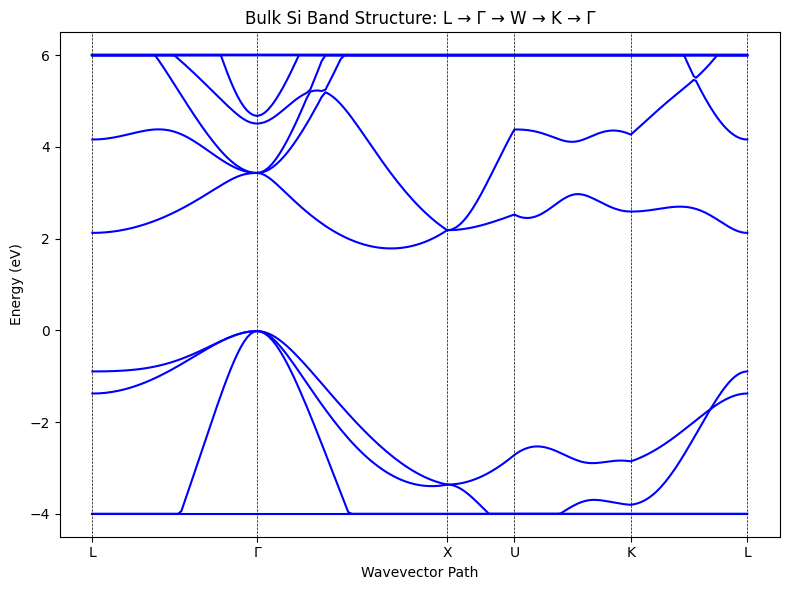

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ===== High-Symmetry Points =====


G =np.array([0.0, 0.0, 0.0])
L =  np.array([0.5, 0.5, 0.5])
K = np.array([0.75,0.75,0.0])
X = np.array([0, 1, 0])
W = np.array([1.0, 0.5, 0.0])
U = np.array([0.25  , 1, 0.25])

hs_points = [('L',L), ('Γ',G), ('X',X), ('U',U), ('K',K), ('L',L)]



def linpath(k_start, k_end, N):
    """Generate N points between k_start and k_end (excluding the endpoint)."""
    return np.linspace(k_start, k_end, N, endpoint=False)

    
num_points_per_segment = 50  
k_points = []
k_path_dist = []  
hs_labels = []    

# Initialize with the first high-symmetry point.
k_points.append(hs_points[0][1])
k_path_dist.append(0.0)
hs_labels.append((hs_points[0][0], 0.0))

# Loop over segments between high-symmetry points.
for i in range(len(hs_points) - 1):
    label_start, k_start = hs_points[i]
    label_end, k_end = hs_points[i+1]
    segment = linpath(k_start, k_end, num_points_per_segment)
   
    for k in segment:
        # Skip the first point of each segment to avoid duplicates (except for the very first segment)
        if np.allclose(k, k_points[-1]):
            continue
        k_points.append(k)
        # Distance from the previous point
        delta = np.linalg.norm(k - k_points[-2])
        k_path_dist.append(k_path_dist[-1] + delta)
    
    # Mark the high-symmetry endpoint:
    # (Make sure to include the final point of the segment)
    if not np.allclose(k_points[-1], k_end):
        k_points.append(k_end)
        delta = np.linalg.norm(k_end - k_points[-2])
        k_path_dist.append(k_path_dist[-1] + delta)
    hs_labels.append((label_end, k_path_dist[-1]))


bands = [] 

for k in k_points:
    
    eigvals,H = create_bulk_tight_binding(k, a)
   
    bands.append(eigvals)
bands = np.array(bands)  
#only display correct range
Emin, Emax = -4, 6.0
bands = np.clip(bands, Emin, Emax)        # values outside range are clamped

                   # <<< restrict y-axis

# ===== Plot the Band Structure =====
plt.figure(figsize=(8,6))
num_bands = bands.shape[1]
for band in range(num_bands):
    plt.plot(k_path_dist, bands[:, band], 'b-')

# Mark the high-symmetry points on the plot.
hs_positions = [dist for (label, dist) in hs_labels]
hs_names = [label for (label, dist) in hs_labels]
for pos in hs_positions:
    plt.axvline(x=pos, color='k', linestyle='--', linewidth=0.5)
plt.xticks(hs_positions, hs_names)
plt.xlabel("Wavevector Path")
plt.ylabel("Energy (eV)")
plt.title("Bulk Si Band Structure: L → Γ → W → K → Γ")
plt.tight_layout()
plt.show()


In [5]:
import numpy as np, math
import scipy as spc
# physical constants


# INCORRECT
def eff_mass_bulk(klen=100, band=None):
    k_axis = np.linspace(-1, 1, klen, endpoint=False) * _2pi_over_a
    dk     = k_axis[1] - k_axis[0]

    nbands = len(create_bulk_tight_binding(np.zeros(3))[0])
    if band is None:
        band = nbands // 2            # first conduction band

    E = np.empty((klen**3, nbands))
    idx = 0
    for kx in k_axis:
        for ky in k_axis:
            for kz in k_axis:
                E[idx] = np.sort(create_bulk_tight_binding(
                                   np.array([kx, ky, kz]), a)[0].real)
                idx += 1
    E = E.reshape(klen, klen, klen, nbands)
    band_E = E[..., band]             

    ix, iy, iz = np.unravel_index(band_E.argmin(), band_E.shape)
    
    r = lambda i: i % klen            # periodic wrap

    d2Ex = (band_E[r(ix-1), iy, iz] + band_E[r(ix+1), iy, iz]
            - 2*band_E[ix, iy, iz]) / dk**2
    d2Ey = (band_E[ix, r(iy-1), iz] + band_E[ix, r(iy+1), iz]
            - 2*band_E[ix, iy, iz]) / dk**2
    d2Ez = (band_E[ix, iy, r(iz-1)] + band_E[ix, iy, r(iz+1)]
            - 2*band_E[ix, iy, iz]) / dk**2

    d2Exy = (band_E[r(ix+1), r(iy+1), iz] + band_E[r(ix-1), r(iy-1), iz]
            - band_E[r(ix+1), r(iy-1), iz] - band_E[r(ix-1), r(iy+1), iz]) / (4*dk**2)
    d2Exz = (band_E[r(ix+1), iy, r(iz+1)] + band_E[r(ix-1), iy, r(iz-1)]
            - band_E[r(ix+1), iy, r(iz-1)] - band_E[r(ix-1), iy, r(iz+1)]) / (4*dk**2)
    d2Eyz = (band_E[ix, r(iy+1), r(iz+1)] + band_E[ix, r(iy-1), r(iz-1)]
            - band_E[ix, r(iy+1), r(iz-1)] - band_E[ix, r(iy-1), r(iz+1)]) / (4*dk**2)
    
    H_eV_m2 = np.array([[d2Ex,  d2Exy, d2Exz],
                        [d2Exy, d2Ey,  d2Eyz],
                        [d2Exz, d2Eyz, d2Ez]])

    H_J_m2 = H_eV_m2 * EV_TO_J
    m_inv  = H_J_m2 / hbar**2
    m_tensor = 1 / m_inv

    return m_tensor, H_eV_m2, (ix, iy, iz), band_E[ix, iy, iz]





### sp3 dictionary

In [6]:
a    = 5.44e-10   
hbar = spc.constants.hbar 
a    = 5.44e-10                   
_2pi_over_a = 2*np.pi / a
EV_TO_J  = 1.602176634e-19
SK = {
    ('s', 's'): lambda l, m, n, V: V['ss'],
    ('s', 'px'): lambda l, m, n, V:  l * V['sp'],
    ('px', 's'): lambda l, m, n, V: -l * V['sp'],

    ('s', 'py'): lambda l, m, n, V:  m * V['sp'],
    ('py', 's'): lambda l, m, n, V: -m * V['sp'],

    ('s', 'pz'): lambda l, m, n, V:  n * V['sp'],
    ('pz', 's'): lambda l, m, n, V: -n * V['sp'],

    ('px', 'px'): lambda l, m, n, V: l**2 * V['pp_sigma'] + (1 - l**2) * V['pp_pi'],
    ('py', 'py'): lambda l, m, n, V: m**2 * V['pp_sigma'] + (1 - m**2) * V['pp_pi'],
    ('pz', 'pz'): lambda l, m, n, V: n**2 * V['pp_sigma'] + (1 - n**2) * V['pp_pi'],

    ('px', 'py'): lambda l, m, n, V: l * m * (V['pp_sigma'] - V['pp_pi']),
    ('px', 'pz'): lambda l, m, n, V: l * n * (V['pp_sigma'] - V['pp_pi']),
    ('py', 'pz'): lambda l, m, n, V: m * n * (V['pp_sigma'] - V['pp_pi']),

    ('py', 'px'): lambda l, m, n, V: l * m * (V['pp_sigma'] - V['pp_pi']),
    ('pz', 'px'): lambda l, m, n, V: l * n * (V['pp_sigma'] - V['pp_pi']),
    ('pz', 'py'): lambda l, m, n, V: m * n * (V['pp_sigma'] - V['pp_pi']),
}


V_ss_sigma = -1.95933#Vss / 4
V_sp_sigma = 3.02562 #np.sqrt(3) / 4 * Vsp
V_pp_pi = -1.51801#diff1 / 4
V_pp_sigma = 4.10364#(Vxy + 4 * V_pp_pi /3) * 3 / 4
a = 1   

Es,Ep =  -2.15168, 4.22925
E = {'s': Es, 'px': Ep, 'py': Ep, 'pz': Ep}
V = {
    'ss': V_ss_sigma,
    'sp': V_sp_sigma,
    'pp_sigma': V_pp_sigma,
    'pp_pi': V_pp_pi
}

distance = np.sqrt(3)/4
base_angle = np.sqrt(1/3)
unitCellDict = {
    (0.0, 0.0, 0.0): [ 
        {"neighbor_position": (0.25, 0.25, 0.25), 
         "delta": (0.25, 0.25, 0.25),
         "distance": distance,
         "l":  base_angle, "m":  base_angle, "n":  base_angle},
        {"neighbor_position": (0.25, -0.25, -0.25), 
         "delta": (0.25, -0.25, -0.25),
         "distance": distance,
         "l":  base_angle, "m": -base_angle, "n": -base_angle},
        {"neighbor_position": (-0.25, 0.25, -0.25), 
         "delta": (-0.25, 0.25, -0.25),
         "distance": distance,
         "l": -base_angle, "m":  base_angle, "n": -base_angle},
        {"neighbor_position": (-0.25, -0.25, 0.25), 
         "delta": (-0.25, -0.25, 0.25),
         "distance": distance,
         "l": -base_angle, "m": -base_angle, "n":  base_angle},
    ],
    (0.25, 0.25, 0.25): [
        {"neighbor_position": (0.0, 0.0, 0.0), 
         "delta": (-0.25, -0.25, -0.25),
         "distance": distance,
         "l": -base_angle, "m": -base_angle, "n": -base_angle},
        {"neighbor_position": (0.0, 0.5, 0.5), 
         "delta": (-0.25, 0.25, 0.25),
         "distance": distance,
         "l": -base_angle, "m":  base_angle, "n":  base_angle},
        {"neighbor_position": (0.5, 0.0, 0.5), 
         "delta": (0.25, -0.25, 0.25),
         "distance": distance,
         "l":  base_angle, "m": -base_angle, "n":  base_angle},
        {"neighbor_position": (0.5, 0.5, 0.0), 
         "delta": (0.25, 0.25, -0.25),
         "distance": distance,
         "l":  base_angle, "m":  base_angle, "n": -base_angle},
    ]
}